In [118]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import qiskit.opflow as of
from qiskit.circuit.random import random_circuit
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector

from variational_algorithms import VQE, energy_evaluation, classical_solver
from costfunc_barren_plateaus import global2local
#from state_efficient_ansatz import SCL, LBCL

In [119]:
def cnot_layer( n_qbits, n_cnot='Full_connect' ):   
    sysA = int( n_qbits/2 )
    circ = QuantumCircuit( n_qbits )
        
    if isinstance( n_cnot, int ):
        for indx in range( n_cnot ):
            circ.cnot( indx , indx + sysA )

    elif n_cnot == 'Full_connect':        
        for indx in range( sysA ):
            circ.cnot( indx , indx + sysA )

    else:
        n_cnot = np.shape( n_cnot )[0]
        for indx in range( n_cnot ):
            circ.cnot( n_cnot[indx][0] , n_cnot[indx][1] )
            
    return circ


def parity_test( n ):
    if n%2 == 0:
        p = 0
    else:
        p = -1
    
    return p

In [120]:


def _GateSmith( params, qubits, n_qbits_crz=2, deep=1, name=None ):
      
    qubits= len( qubits )
    par = parity_test( qubits )
    qc = QuantumCircuit( qubits, name=name )
        
    for i in range( qubits ):
        qc.ry( params[i], i )

    cc = -1
    for _ in range( 1, deep+1 ):

        for i in range( 0 , qubits + par, n_qbits_crz ):
            for l in range( 1, n_qbits_crz ):
                cc += 1
                qc.cz( i, i+l )
        
        for i in range( qubits ):
            cc += 1
            qc.ry( params[ qubits + cc ], i )

        for i in range( 1, qubits-1, n_qbits_crz ):
            for l in range( 1, n_qbits_crz ):
                cc += 1
                qc.cz( i, i+l )


    return qc.to_gate( )


def _GateBasis( params, qubits , name=None ):

    qc = QuantumCircuit( len(qubits) , name=name )
    qc.u(params[0], params[1], params[2], qc.qubits[0])
    qc.u(params[3], params[4], params[5], qc.qubits[1])

    qc.rxx(params[6], qc.qubits[0], qc.qubits[1])
    qc.ryy(params[7], qc.qubits[0], qc.qubits[1])
    qc.rzz(params[8], qc.qubits[0], qc.qubits[1])

    qc.u(params[ 9], params[10], params[11], qc.qubits[0])
    qc.u(params[12], params[13], params[14], qc.qubits[1])

    return qc.to_gate()





In [121]:
#def SCL( self, params, qubits, n_qbits_crz=2, deep=1, name=None ):
def SCL( params, qubits, n_qbits_crz=2, deep=1, name=None ):
    "Schmidt Coefficient Layer"
    #assert ( (qubits[-1]+1)%2 == 0 ) and ( type(qubits) == list ), "The qubits must be given in a list and the total number of qubits must be an even integer."

    #self.append( _GateSmith( params, qubits, n_qbits_crz=n_qbits_crz, deep=deep, name=name ), qubits )
    qc = _GateSmith( params, qubits, n_qbits_crz=n_qbits_crz, deep=deep, name=name )

    return qc 
    
def LBCL( params, qubits, name=None ):
    "Local Basis Changing Layer"
    #assert ( (qubits[-1]+1)%2 == 0 ) and ( type(qubits) == list ), "The qubits must be given in a list and the total number of qubits must be an even integer."
    
    #self.append( _GateBasis( params, qubits, name=name ), qubits )
    qc = _GateBasis( params, qubits, name=name )

    return qc

In [122]:
def ansatz_constructor( qubits, unitaries=[SCL, SCL, SCL], n_qb_crz=[2,2,2], deep= [1,1,1], n_cnot='Full_connect' ):
    
    #assert isinstance( n_cnot, int ) or isinstance( n_cnot, list ) or ( n_cnot == 'Full_connect' ), "The variable n_cnot must be of type integer or a numpy.ndarray"
    #assert isinstance( unitaries, list ), "The unitaries must be given in a numpy.ndarray variable"
    
    num_params_SCL = ( deep[0] +1 )*qubits
    
    
    params = ParameterVector("θ", num_params_SCL*3)
    qc     = QuantumCircuit( qubits )
    

    U_1   = unitaries[0]( params, range( int(qubits/2) ), n_qbits_crz=int(n_qb_crz[0]), deep=deep[0], name="U1" )
    U_2   = unitaries[1]( params, range( int(qubits/2) ), n_qbits_crz=int(n_qb_crz[1]), deep=deep[1], name="U2" )
    U_3   = unitaries[2]( params, range( int(qubits/2) ), n_qbits_crz=int(n_qb_crz[2]), deep=deep[2], name="U3" )
    ent_l = cnot_layer( qubits, n_cnot=n_cnot )

    qc.compose( U_1 , qubits=range( int(qubits/2) ), clbits=None, inplace=True )         # Compose entangled layer cnots
    qc.barrier()
    
    qc.compose( ent_l , qubits=range( qubits ), clbits=None, inplace=True )              # Compose entangled layer cnots
    qc.barrier()
    
    qc.compose( U_2 , qubits=range( int(qubits/2) ), clbits=None, inplace=True )         # Compose entangled layer cnots
    qc.compose( U_3 , qubits=range( int(qubits/2), qubits ), clbits=None, inplace=True ) # Compose entangled layer cnots
    
    return qc

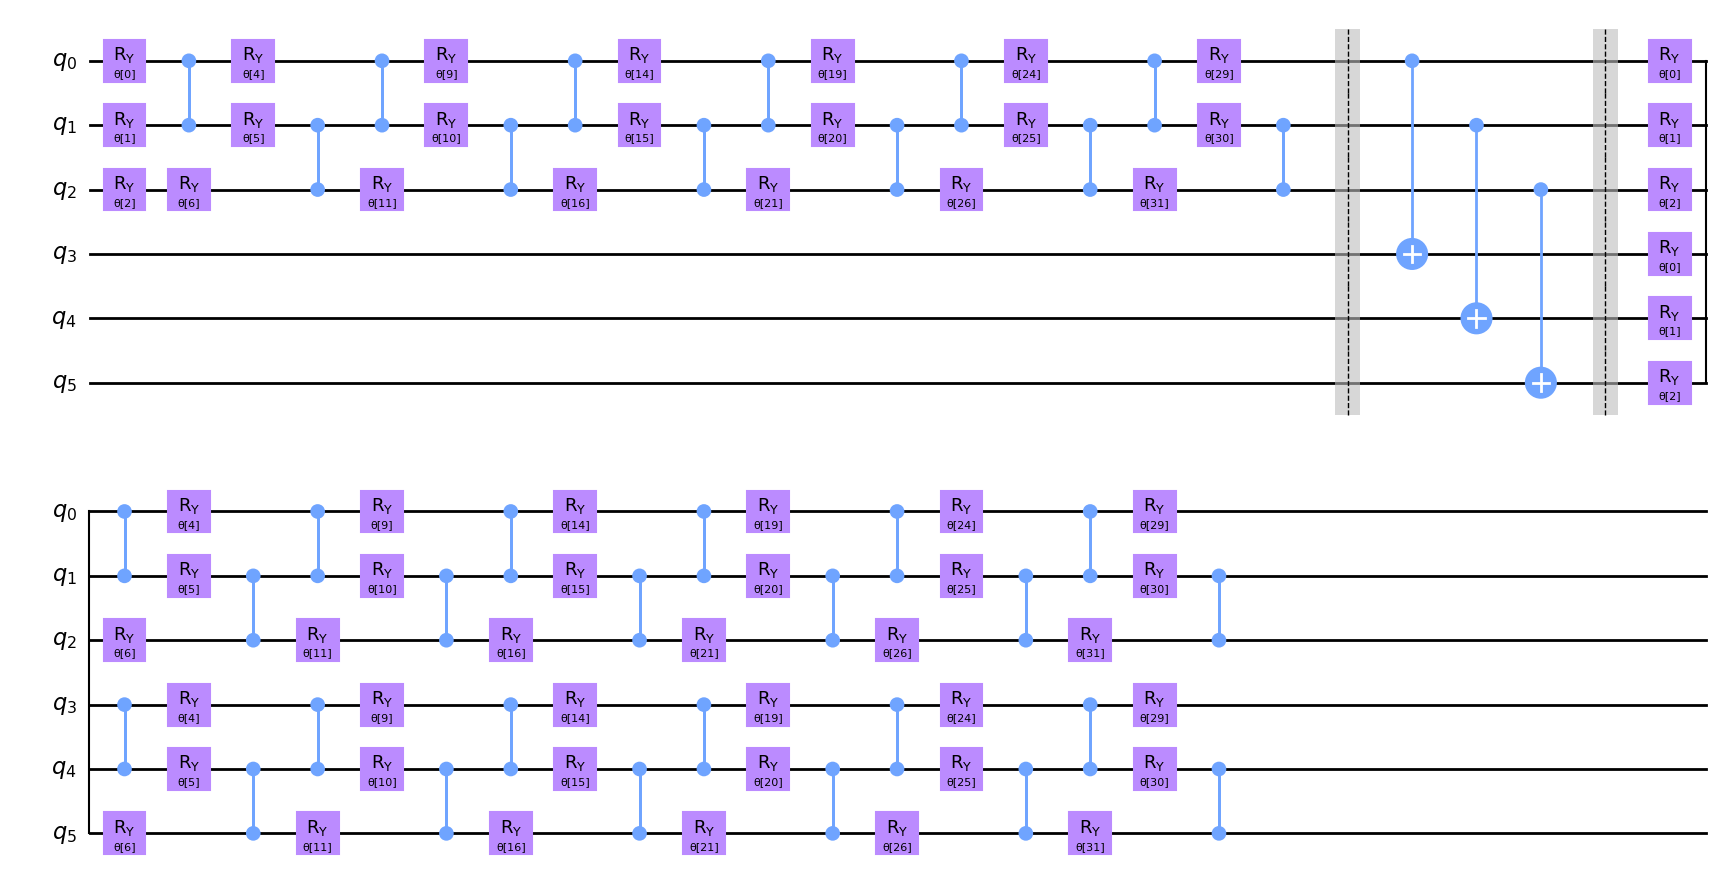

In [123]:
num_qubits = 6
reps       = 6


ansatz   = ansatz_constructor( num_qubits, deep=[reps,reps,reps]) #, n_cnot=2 )
t_ansatz = transpile(ansatz)

params = np.random.rand(t_ansatz.num_parameters) * np.pi
ansatz.decompose().draw( 'mpl' )

In [124]:
X = of.X #Pauli X
Y = of.Y #Pauli Y
Z = of.Z #Pauli Z
I = of.I #Identidad

lamb  = 1
delt  = 0.5

H_int = (Z^Z^I^I^I) + (I^Z^Z^I^I) + (I^I^Z^Z^I) + (I^I^I^Z^Z)
H_x   = lamb*(X^I^I^I^I) + (I^X^I^I^I) + (I^I^X^I^I) + (I^I^I^X^I) + (I^I^I^I^X)
H_z   = delt*(Z^I^I^I^I) + (I^Z^I^I^I) + (I^I^Z^I^I) + (I^I^I^Z^I) + (I^I^I^I^Z)

H     = H_x + H_z + H_int

#H_local = global2local( H )


In [125]:
optimizer = SPSA
simulator_def   = AerSimulator(shots = 2**14)

params = np.random.rand(t_ansatz.num_parameters) * np.pi

In [126]:
results_global = VQE( H, ansatz, params, optimizer(), simulator_def )
print( results_global.fun )

-3.53900146484375
